In [1]:
import pandas as pd 
import numpy as np


import gc
import random
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
random.seed(2023)

# Load Data

In [3]:
df = pd.read_csv("/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")

In [4]:
df.shape

(5110, 12)

In [5]:
display(df.head())

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


<AxesSubplot:>

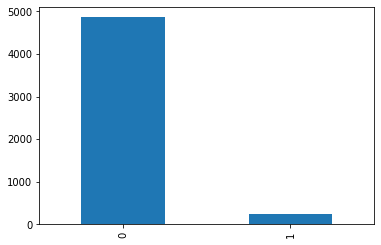

In [6]:
df.stroke.value_counts().plot.bar()

In [7]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

# Impute missing values in BMI

In [8]:
# Here we use simple mean value to impute missing values in BMI

df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

In [9]:
# extract categorical features

categorical_features = df.columns[df.dtypes == 'object'].tolist()

print(categorical_features)

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [10]:
numerical_features = df.columns.difference(categorical_features + ['id', 'stroke']).tolist()

print(numerical_features)

['age', 'avg_glucose_level', 'bmi', 'heart_disease', 'hypertension']


# Data Preparation Pipeline

In [11]:
embedding_dims = {
    
    k : (df[k].nunique(), df[k].nunique() // 2)
    
    for k in categorical_features
}

embedding_dims

{'gender': (3, 1),
 'ever_married': (2, 1),
 'work_type': (5, 2),
 'Residence_type': (2, 1),
 'smoking_status': (4, 2)}

*Feature Transformer*

In [12]:
#Convert data inot a multi-input list format to match the model architecture
def feature_transformer(train, test):

    input_list_train = []
    input_list_test = []
    
    # Extract all columns(categorical) to be fed into an embedding layer
    for c in categorical_features:
        # all unique categories in column `c`
        raw_vals = np.unique(train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            # encode unique categories in column `c`
            val_map[raw_vals[i]] = i       
            
        input_list_train.append(train[c].map(val_map).values)
        input_list_test.append(test[c].map(val_map).values)
     
    # Extract remaining non-embedding columns - input of numeric the feedforward embedding layer
    num_cols = [c for c in train.columns if (not c in categorical_features + ['id', 'stroke'])]
    input_list_train.append(train[num_cols].values)
    input_list_test.append(test[num_cols].values)
    
    
    return input_list_train, input_list_test  

# Create Train/Test Split

In [13]:
df['stroke'] = df['stroke'].astype(int)

In [14]:
# We will first create train/test splits

df_train, df_test, y_train, y_test = train_test_split(df, df['stroke'], test_size =0.2, stratify=df['stroke'], shuffle=True, random_state =2023)


print(f'(train X , train y): {df_train.shape, y_train.shape}, (test X, test y) : {df_test.shape, y_test.shape}')

(train X , train y): ((4088, 12), (4088,)), (test X, test y) : ((1022, 12), (1022,))


In [15]:
gc.collect()

88

# Model

In [21]:
def get_model(num_numeric_cols):

    act_fn = 'relu'
    
    dr = 0.2
    
    lr = 0.001

    inputs = []
    embeddings = []


    for i in embedding_dims.keys():

        input = tf.keras.layers.Input(shape=(1), dtype = tf.int32)

        x, y = embedding_dims[i]

        emb = tf.keras.layers.Embedding(x, y,  input_length = 1)(input)

        emb = tf.keras.layers.Reshape(target_shape=(y,))(emb)

        inputs.append(input)
        embeddings.append(emb)


    inp = tf.keras.Input(shape=(num_numeric_cols, ), name ="numeric_features", dtype = tf.float32)   
    num_emb = tf.keras.layers.Dense(256, activation = act_fn)(inp)

    inputs.append(inp)
    embeddings.append(num_emb)

    x = tf.keras.layers.Concatenate()(embeddings)

    x = tf.keras.layers.Dense( 128, activation = act_fn)(x)  
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(rate=dr)(x)   

    x = tf.keras.layers.Dense( 128, activation = act_fn)(x)  
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(rate=dr)(x) 
    

    preds = tf.keras.layers.Dense(1,activation = 'sigmoid' , name ="classifier")(x)

    model = tf.keras.models.Model(inputs = inputs ,outputs = preds )
    
  
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(loss= "binary_crossentropy",
                optimizer= opt,
                metrics = ['Accuracy']
                )
    
    return model

# Train Model

In [17]:
X_train, X_test = feature_transformer( train = df_train, test = df_test  )

Y_train , Y_test = y_train.values, y_test.values

In [22]:
batch_size = 32
epochs = 100

n_num_cols = len(numerical_features)

es = tf.keras.callbacks.EarlyStopping(patience=50, mode='min', verbose=1, monitor = "val_loss", min_delta = 0.00001, restore_best_weights=True) 

# init model
model = get_model(num_numeric_cols = n_num_cols)

model.fit(
        X_train, Y_train,
        validation_data = (X_test, Y_test),
        batch_size = batch_size,
        epochs = epochs,
        callbacks = [es],
        )

Epoch 1/100
128/128 [==============================] - 3s 9ms/step - loss: 0.5026 - Accuracy: 0.7921 - val_loss: 0.4618 - val_Accuracy: 0.8268
Epoch 2/100
128/128 [==============================] - 1s 7ms/step - loss: 0.2476 - Accuracy: 0.9325 - val_loss: 0.1662 - val_Accuracy: 0.9511
Epoch 3/100
128/128 [==============================] - 1s 7ms/step - loss: 0.2021 - Accuracy: 0.9408 - val_loss: 0.1742 - val_Accuracy: 0.9511
Epoch 4/100
128/128 [==============================] - 1s 8ms/step - loss: 0.1833 - Accuracy: 0.9447 - val_loss: 0.1589 - val_Accuracy: 0.9511
Epoch 5/100
128/128 [==============================] - 1s 8ms/step - loss: 0.1918 - Accuracy: 0.9437 - val_loss: 0.1688 - val_Accuracy: 0.9442
Epoch 6/100
128/128 [==============================] - 1s 9ms/step - loss: 0.1836 - Accuracy: 0.9447 - val_loss: 0.1585 - val_Accuracy: 0.9511
Epoch 7/100
128/128 [==============================] - 1s 7ms/step - loss: 0.1817 - Accuracy: 0.9467 - val_loss: 0.2370 - val_Accuracy: 0.9511

In [29]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

y_pred  = (y_pred > 0.5).astype(int)

y_pred

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [30]:
print('Accuracy:', accuracy_score(Y_test, y_pred))

Accuracy: 0.9510763209393346
